In [1]:
!gdown --id 152PXuKYuKXvzAg1DT2s5ZCcStC5iezzi

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=152PXuKYuKXvzAg1DT2s5ZCcStC5iezzi
To: /content/senior_ds_test.zip
100% 50.6M/50.6M [00:00<00:00, 68.7MB/s]


In [2]:
!unzip senior_ds_test.zip

Archive:  senior_ds_test.zip
   creating: senior_ds_test/
   creating: senior_ds_test/.ipynb_checkpoints/
   creating: senior_ds_test/data/
   creating: senior_ds_test/data/.ipynb_checkpoints/
   creating: senior_ds_test/data/final_submission/
  inflating: senior_ds_test/data/final_submission/sample_submission.csv  
   creating: senior_ds_test/data/test/
  inflating: senior_ds_test/data/test/accounts_data_test.json  
  inflating: senior_ds_test/data/test/enquiry_data_test.json  
  inflating: senior_ds_test/data/test/test_flag.csv  
   creating: senior_ds_test/data/train/
  inflating: senior_ds_test/data/train/accounts_data_train.json  
  inflating: senior_ds_test/data/train/enquiry_data_train.json  
  inflating: senior_ds_test/data/train/train_flag.csv  
  inflating: senior_ds_test/problem_statement.pdf  


# Feature Engineering

1. **Data Loading and Flattening**
   - The JSON files are read and flattened using custom functions. Data from CSV files is also loaded.

2. **Preprocessing and Cleanup**
   - Various preprocessing steps such as handling missing values and filtering records based on certain conditions are carried out.

3. **Feature Extraction from Payment History**
   - Payment history is processed to extract various features like the number of days a payment was late.

4. **Aggregating Features**
   - The features extracted are aggregated on a per-user basis using grouping and summarizing techniques.

5. **Pivot Tables and Feature Renaming**
   - Pivot tables are used to reshape data and multi-level columns are flattened by renaming.

6. **Calculating New Features**
   - New features are calculated based on existing ones such as loan duration, amount overdue, and others.

7. **Feature Engineering on Enquiry Data**
   - Similar to the accounts data, enquiry data is also processed to extract and aggregate features.

8. **Time-based Features**
   - Features based on time such as recency and frequency are calculated, e.g., days since last enquiry.

9. **Interaction Features**
   - Interaction features are created by combining two or more features to create new ones, like the ratio of total enquiry amount to total loan amount.

10. **Active Loan Features**
    - Features related to active loans, like the ratio of active loans to total loans, are created.

11. **Average and Ratio Calculations**
    - Various averages and ratios are calculated to create new features.

12. **Loan Frequency and Time Between Loans**
    - The frequency of loans and average time between consecutive loans are calculated.

13. **Aggregating Features**
    - All the created features are aggregated at the user level to create a summarized view.

14. **Feature Selection using Random Forest Importance**
    - (Not included in the code) After creating and aggregating features, a Random Forest model can be used to evaluate feature importance. This helps in selecting the most relevant features for the predictive model.

### Explanation

- In the below code, various steps of feature engineering are carried out to process and extract meaningful information from the raw data. This includes cleaning, transformation, and the creation of new features that could provide valuable insights or improve the performance of machine learning models.

- Different types of features are engineered such as aggregated, time-based, interaction, and ratio features. These features are expected to capture various aspects and patterns in the data, helping in uncovering the underlying relationships.

- Note that the final step mentioned (Random Forest Importance for feature selection) is typically done after feature engineering. A Random Forest model is trained on the engineered features, and the importance of each feature is evaluated. Features that are found to be less important can be dropped to reduce dimensionality and potentially improve the model’s performance.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

def read_provided_json_file_to_df(filename):
  f=open(filename)
  data_json = json.load(f)
  f_data_json=flatten_extend(data_json)
  df=pd.json_normalize(f_data_json)
  return df

def process_dataset(flag_file,accounts_file,enquiry_file,is_training_data=True):
  # Load Train Data
  processed_data = pd.read_csv(flag_file)

  # Load Accounts Data
  accounts_data=read_provided_json_file_to_df(accounts_file)

  # Load enquiry Data
  enquiry_data=read_provided_json_file_to_df(enquiry_file)
  if is_training_data:
    accounts_data.dropna(subset=['loan_amount'], inplace=True)
  else:
    accounts_data['loan_amount'].dropna(0, inplace=True)
  # Mark Loan as open where closed date is not present
  accounts_data['is_open'] = accounts_data['closed_date'].isna().astype(int)
  if is_training_data:
  # Removing rows where closed_date is earlier than open_date
    accounts_data = accounts_data[accounts_data['closed_date'] >= accounts_data['open_date']]
  def extract_payment_features(payment_hist_string):
      # Splitting the string into chunks of 3 digits representing each month
      payments = [int(payment_hist_string[i:i+3]) for i in range(0, len(payment_hist_string), 3)]

      payment_features = {
          '1-30_days_late': sum(1 <= p <= 30 for p in payments),
          '31-60_days_late': sum(31 <= p <= 60 for p in payments),
          '61-90_days_late': sum(61 <= p <= 90 for p in payments),
          'more_than_90_days_late': sum(p > 90 for p in payments)
      }

      return payment_features

  # Applying the function to the payment_hist_string column
  accounts_data['payment_features'] = accounts_data['payment_hist_string'].apply(extract_payment_features)

  # Extracting the values into separate columns
  accounts_data[['1-30_days_late', '31-60_days_late', '61-90_days_late', 'more_than_90_days_late']] = pd.DataFrame(accounts_data['payment_features'].tolist(), index=accounts_data.index)

  # Dropping the now redundant payment_features column
  accounts_data.drop(columns=['payment_features'], inplace=True)

  # Now,  aggregating these features on a per user basis, using a groupby operation on 'uid'
  payment_features_agg = accounts_data.groupby('uid').agg({
      '1-30_days_late': 'sum',
      '31-60_days_late': 'sum',
      '61-90_days_late': 'sum',
      'more_than_90_days_late': 'sum'
  }).reset_index()
  loan_summary = accounts_data.groupby(['uid', 'credit_type']).agg(
      total_loan_amount=pd.NamedAgg(column='loan_amount', aggfunc='sum'),
      loan_count=pd.NamedAgg(column='loan_amount', aggfunc='count')
  ).reset_index()

  account_pivot_table = pd.pivot_table(loan_summary, values=['total_loan_amount', 'loan_count'],
                              index='uid', columns='credit_type', fill_value=0)

  # Flattening the multi-level columns
  account_pivot_table.columns = ['_'.join(col).strip() for col in account_pivot_table.columns.values]

  # Resetting the index to prepare for merging
  account_pivot_table.reset_index(inplace=True)
  # Feature Engineering for Accounts Data
  accounts_data['loan_duration'] = (pd.to_datetime(accounts_data['closed_date']) -
                                  pd.to_datetime(accounts_data['open_date'])).dt.days
  accounts_features = accounts_data.groupby('uid').agg({
      'loan_amount': ['sum', 'mean', 'max', 'min'],
      'amount_overdue': 'sum',
      'loan_duration': ['mean', 'max', 'min'],
      'uid': 'count',
      'is_open':'sum'
  }).reset_index()
  accounts_features.columns = ['uid', 'total_loan_amount', 'avg_loan_amount', 'max_loan_amount', 'min_loan_amount',
                              'total_overdue_amount', 'avg_loan_duration', 'max_loan_duration', 'min_loan_duration',
                              'loan_count','open_loans']

  # Feature Engineering for Enquiry Data
  enquiry_features = enquiry_data.groupby('uid').agg({
      'enquiry_amt': ['sum', 'mean', 'max', 'min'],
      'uid': 'count'
  }).reset_index()
  enquiry_features.columns = ['uid', 'total_enquiry_amount', 'avg_enquiry_amount', 'max_enquiry_amount',
                              'min_enquiry_amount', 'enquiry_count']

  enquiry_summary = enquiry_data.groupby(['uid', 'enquiry_type']).agg(
      total_enquiry_amount=pd.NamedAgg(column='enquiry_amt', aggfunc='sum'),
      enquiry_count=pd.NamedAgg(column='enquiry_amt', aggfunc='count')
  ).reset_index()

  enq_pivot_table = pd.pivot_table(enquiry_summary, values=['total_enquiry_amount', 'enquiry_count'],
                              index='uid', columns='enquiry_type', fill_value=0)

  # Flattening the multi-level columns
  enq_pivot_table.columns = ['_'.join(col).strip() for col in enq_pivot_table.columns.values]

  # Resetting the index to prepare for merging
  enq_pivot_table.reset_index(inplace=True)


  # Assuming enquiry_data is your DataFrame and it has columns 'enquiry_date', 'enquiry_amt', and 'uid'

  # Convert enquiry_date to datetime
  enquiry_data['enquiry_date'] = pd.to_datetime(enquiry_data['enquiry_date'])

  # Get the maximum date in the dataset
  max_date = enquiry_data['enquiry_date'].max()

  # Defining the periods in days
  periods_in_days = {
      '1_month': 30,
      '3_months': 90,
      '6_months': 180,
      '1_year': 365,
      '3_years': 3*365
  }

  # Create a DataFrame to store the results
  results = enquiry_data[['uid']].drop_duplicates().set_index('uid')

  # For each period, calculate the number of enquiries and total enquiry amount
  for period, days in periods_in_days.items():
      start_date = max_date - timedelta(days=days)

      mask = (enquiry_data['enquiry_date'] > start_date) & (enquiry_data['enquiry_date'] <= max_date)
      filtered_data = enquiry_data[mask]

      # Count the number of enquiries
      enquiry_counts = filtered_data.groupby('uid').size()
      results[f'{period}_enquiry_count'] = enquiry_counts

      # Sum the enquiry amounts
      enquiry_amounts = filtered_data.groupby('uid')['enquiry_amt'].sum()
      results[f'{period}_enquiry_amt'] = enquiry_amounts

  # Resetting index to make uid a column again
  results.reset_index(inplace=True)

  # Fill NaN values with 0
  results.fillna(0, inplace=True)
  # Total enquiry amount and total loan amount
  total_enquiry_amount = enquiry_data.groupby('uid')['enquiry_amt'].sum()
  total_loan_amount = accounts_data.groupby('uid')['loan_amount'].sum()

  # Enquiry count and loan count
  enquiry_count = enquiry_data.groupby('uid').size()
  loan_count = accounts_data.groupby('uid').size()

  # Creating interaction features
  interaction_features = pd.DataFrame({
      'enquiry_loan_amt_ratio': total_enquiry_amount / total_loan_amount,
      'enquiry_loan_count_ratio': enquiry_count / loan_count
  }).reset_index()
  interaction_features.fillna(0,inplace=True)
  # Convert date columns to datetime objects first
  accounts_data['open_date'] = pd.to_datetime(accounts_data['open_date'])
  enquiry_data['enquiry_date'] = pd.to_datetime(enquiry_data['enquiry_date'])

  now = pd.Timestamp('2021-01-1T00:00:00')

  # Getting recency features for loans and enquiries
  last_loan_date = accounts_data.groupby('uid')['open_date'].max()
  first_loan_date = accounts_data.groupby('uid')['open_date'].min()
  last_enquiry_date = enquiry_data.groupby('uid')['enquiry_date'].max()
  first_enquiry_date = enquiry_data.groupby('uid')['enquiry_date'].min()

  time_based_features = pd.DataFrame({
      'days_since_last_loan': (now - last_loan_date).dt.days,
      'days_since_first_loan': (now - first_loan_date).dt.days,
      'days_since_last_enquiry': (now - last_enquiry_date).dt.days,
      'days_since_first_enquiry': (now - first_enquiry_date).dt.days
  }).reset_index()
  time_based_features
  time_based_features.fillna(0,inplace=True)
  active_loans_sum = accounts_data[accounts_data['is_open']==1].groupby('uid')['loan_amount'].sum()
  total_loans_sum = accounts_data.groupby('uid')['loan_amount'].sum()

  active_loan_features = (active_loans_sum / total_loans_sum).reset_index(name='active_loan_ratio')
  active_loan_features.fillna(0,inplace=True)

  # Sorting by 'uid' and 'open_date'
  accounts_data.sort_values(by=['uid', 'open_date'], inplace=True)

  # Grouping by 'uid' and calculating the difference in 'open_date' within each group
  accounts_data['date_diff'] = accounts_data.groupby('uid')['open_date'].diff().dt.days

  # Group by 'uid' again and calculate the mean difference, handling NaN values appropriately
  loan_frequency = accounts_data.groupby('uid')['date_diff'].agg(lambda x: np.nanmean(x.dropna())).reset_index()
  loan_frequency.columns = ['uid', 'avg_time_between_loans']
  loan_frequency.fillna(0,inplace=True)
  # Calculating global averages
  average_loan_amount = accounts_data['loan_amount'].mean()
  average_overdue_amount = accounts_data['amount_overdue'].mean()

  # 1. Number of On-Time Payments
  payments = accounts_data['payment_hist_string'].str.findall(r'\d{3}').apply(lambda x: [int(i) for i in x])
  accounts_data['ontime_payments'] = payments.apply(lambda x: x.count(0))

  # 2. Flag for Large Loan Amounts
  accounts_data['large_loan_flag'] = (accounts_data['loan_amount'] > average_loan_amount).astype(int)

  # 3. Flag for High Overdue Amounts
  accounts_data['high_overdue_flag'] = (accounts_data['amount_overdue'] > average_overdue_amount).astype(int)
  # Aggregating the features at the user level
  agg_features = accounts_data.groupby('uid').agg({
      'ontime_payments': 'sum',
      'large_loan_flag': 'mean',
      'high_overdue_flag': 'mean'
  }).reset_index()

  # Sort the data based on uid and open_date to calculate differences
  accounts_data.sort_values(by=['uid', 'open_date'], inplace=True)

  # Calculate the difference between consecutive loan amounts for each user
  accounts_data['loan_amount_diff'] = accounts_data.groupby('uid')['loan_amount'].diff()

  # Calculate the difference in days between consecutive loans for each user
  accounts_data['days_between_loans'] = accounts_data.groupby('uid')['open_date'].diff().dt.days

  # Aggregate these features at the user level
  agg_utilization_features = accounts_data.groupby('uid').agg({
      'loan_amount_diff': ['mean', 'max', 'min'],
      'days_between_loans': ['mean', 'max', 'min']
  }).reset_index()

  agg_utilization_features.columns = ['uid', 'avg_loan_amount_diff', 'max_loan_amount_diff', 'min_loan_amount_diff',
                                    'avg_days_between_loans', 'max_days_between_loans', 'min_days_between_loans']


  # Set the reference date
  reference_date = datetime.strptime('2021-01-01', '%Y-%m-%d').date()

  def days_since(payment_hist_string, threshold, today=reference_date):
      payments = [int(payment_hist_string[i:i+3]) for i in range(0, len(payment_hist_string), 3)]
      payments.reverse()  # So that we start from the most recent payment

      for i, days_late in enumerate(payments):
          if days_late >= threshold:
              return i * 30  # Assuming each payment represents a month

      return len(payments) * 30  # If no payment meets the threshold, return the age of the oldest payment

  # Applying the function to the payment_hist_string column for different thresholds
  accounts_data['days_since_last_late'] = accounts_data['payment_hist_string'].apply(lambda x: days_since(x, 1))
  accounts_data['days_since_last_30_days_late'] = accounts_data['payment_hist_string'].apply(lambda x: days_since(x, 30))
  accounts_data['days_since_last_60_days_late'] = accounts_data['payment_hist_string'].apply(lambda x: days_since(x, 60))
  accounts_data['days_since_last_90_days_late'] = accounts_data['payment_hist_string'].apply(lambda x: days_since(x, 90))

  agg_temp_features = accounts_data.groupby('uid').agg({
      'days_since_last_late': 'min',
      'days_since_last_30_days_late': 'min',
      'days_since_last_60_days_late': 'min',
      'days_since_last_90_days_late': 'min',
      '1-30_days_late': 'sum',
      '31-60_days_late': 'sum',
      '61-90_days_late': 'sum',
      'more_than_90_days_late': 'sum',
  }).reset_index()
  # Merging the Engineered Features back to the Training Data
  processed_data = processed_data.merge(accounts_features, on='uid', how='left')
  processed_data = processed_data.merge(enquiry_features, on='uid', how='left')
  processed_data= processed_data.merge(payment_features_agg,on='uid', how='left')
  processed_data=processed_data.merge(account_pivot_table,on='uid', how='left')
  processed_data=processed_data.merge(enq_pivot_table,on='uid', how='left')
  processed_data=processed_data.merge(results,on='uid', how='left')
  processed_data=processed_data.merge(interaction_features,on='uid', how='left')
  processed_data=processed_data.merge(time_based_features,on='uid', how='left')
  processed_data=processed_data.merge(active_loan_features,on='uid', how='left')
  processed_data=processed_data.merge(loan_frequency,on='uid', how='left')
  processed_data = processed_data.merge(agg_features, on='uid', how='left')
  processed_data = processed_data.merge(agg_utilization_features, on='uid', how='left')
  processed_data = processed_data.merge(agg_temp_features, on='uid', how='left')
  processed_data=processed_data.fillna(0)
  labels=list(processed_data["NAME_CONTRACT_TYPE"].unique())

  # Label Encoding the NAME_CONTRACT_TYPE column
  processed_data["NAME_CONTRACT_TYPE"] = processed_data.apply(lambda x:labels.index(x["NAME_CONTRACT_TYPE"]),axis=1)
  processed_data.replace([np.inf, -np.inf], 0, inplace=True)
  if is_training_data or 'TARGET' in list(processed_data.columns):
    processed_data=processed_data[['uid','TARGET','enquiry_count',
            '1_year_enquiry_count',
            'days_since_first_enquiry',
            'days_since_first_loan',
            'avg_loan_duration',
            'total_enquiry_amount',
            'days_since_last_loan',
            '6_months_enquiry_amt',
            'enquiry_loan_amt_ratio',
            'avg_loan_amount_diff',
            'avg_time_between_loans',
            '6_months_enquiry_count',
            'min_loan_amount',
            'days_since_last_enquiry',
            'min_loan_duration',
            'min_loan_amount_diff',
            '1_year_enquiry_amt',
            'total_loan_amount_Microloan',
            'max_enquiry_amount',
            'total_loan_amount',
            'max_loan_duration',
            'avg_loan_amount',
            'NAME_CONTRACT_TYPE',
            '1_month_enquiry_amt']]
  else:
    processed_data=processed_data[['uid','enquiry_count',
            '1_year_enquiry_count',
            'days_since_first_enquiry',
            'days_since_first_loan',
            'avg_loan_duration',
            'total_enquiry_amount',
            'days_since_last_loan',
            '6_months_enquiry_amt',
            'enquiry_loan_amt_ratio',
            'avg_loan_amount_diff',
            'avg_time_between_loans',
            '6_months_enquiry_count',
            'min_loan_amount',
            'days_since_last_enquiry',
            'min_loan_duration',
            'min_loan_amount_diff',
            '1_year_enquiry_amt',
            'total_loan_amount_Microloan',
            'max_enquiry_amount',
            'total_loan_amount',
            'max_loan_duration',
            'avg_loan_amount',
            'NAME_CONTRACT_TYPE',
            '1_month_enquiry_amt']]
  return processed_data.copy()


In [4]:
train_data=process_dataset("senior_ds_test/data/train/train_flag.csv","senior_ds_test/data/train/accounts_data_train.json","senior_ds_test/data/train/enquiry_data_train.json",is_training_data=True)

<ipython-input-3-0bab2b6e1593>:202: RuntimeWarning: Mean of empty slice
  loan_frequency = accounts_data.groupby('uid')['date_diff'].agg(lambda x: np.nanmean(x.dropna())).reset_index()


In [5]:
list(train_data.columns)

['uid',
 'TARGET',
 'enquiry_count',
 '1_year_enquiry_count',
 'days_since_first_enquiry',
 'days_since_first_loan',
 'avg_loan_duration',
 'total_enquiry_amount',
 'days_since_last_loan',
 '6_months_enquiry_amt',
 'enquiry_loan_amt_ratio',
 'avg_loan_amount_diff',
 'avg_time_between_loans',
 '6_months_enquiry_count',
 'min_loan_amount',
 'days_since_last_enquiry',
 'min_loan_duration',
 'min_loan_amount_diff',
 '1_year_enquiry_amt',
 'total_loan_amount_Microloan',
 'max_enquiry_amount',
 'total_loan_amount',
 'max_loan_duration',
 'avg_loan_amount',
 'NAME_CONTRACT_TYPE',
 '1_month_enquiry_amt']

In [6]:
test_data=process_dataset("senior_ds_test/data/test/test_flag.csv","senior_ds_test/data/test/accounts_data_test.json","senior_ds_test/data/test/enquiry_data_test.json",is_training_data=False)

<ipython-input-3-0bab2b6e1593>:30: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  accounts_data['loan_amount'].dropna(0, inplace=True)
<ipython-input-3-0bab2b6e1593>:202: RuntimeWarning: Mean of empty slice
  loan_frequency = accounts_data.groupby('uid')['date_diff'].agg(lambda x: np.nanmean(x.dropna())).reset_index()


In [7]:
test_data

,uid,enquiry_count,1_year_enquiry_count,days_since_first_enquiry,days_since_first_loan,avg_loan_duration,total_enquiry_amount,days_since_last_loan,6_months_enquiry_amt,enquiry_loan_amt_ratio,...,min_loan_duration,min_loan_amount_diff,1_year_enquiry_amt,total_loan_amount_Microloan,max_enquiry_amount,total_loan_amount,max_loan_duration,avg_loan_amount,NAME_CONTRACT_TYPE,1_month_enquiry_amt
0,CMO22835242,8,5.0,854,2832.0,391.000000,1036000,738.0,154000.0,0.100212,...,115.0,-5625000.00,576000.0,0.0,184000,10338078.06,1109.0,795236.773846,0,0.0
1,MRJ34316727,1,0.0,942,1585.0,1050.000000,184000,122.0,0.0,0.103985,...,912.0,-972990.00,0.0,0.0,184000,1769490.00,1188.0,294915.000000,0,0.0
2,UAV00534378,1,0.0,732,2305.0,268.666667,188000,399.0,0.0,0.067045,...,182.0,-76410.00,0.0,0.0,188000,2804085.00,317.0,467347.500000,0,0.0
3,IPQ08190402,21,12.0,847,1841.0,732.333333,2013000,608.0,490000.0,1.917055,...,537.0,-209952.00,1038000.0,0.0,192000,1050048.00,1062.0,210009.600000,0,89000.0
4,NQN84331006,6,5.0,572,2418.0,388.000000,669000,353.0,482000.0,0.153684,...,244.0,-720000.00,585000.0,0.0,170000,4353080.76,616.0,483675.640000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46122,IQY03739314,1,1.0,113,2896.0,343.285714,51000,258.0,51000.0,0.137334,...,118.0,-87153.75,51000.0,0.0,51000,371358.72,1064.0,53051.245714,0,0.0
46123,QIL15152190,20,13.0,790,0.0,0.000000,1960000,0.0,551000.0,0.000000,...,0.0,0.00,1354000.0,0.0,199000,0.00,0.0,0.000000,0,179000.0
46124,HMM67531434,5,4.0,1218,1073.0,579.000000,306000,734.0,195000.0,0.229575,...,572.0,-702900.00,256000.0,0.0,122000,1332900.00,586.0,333225.000000,0,0.0
46125,WWW87911447,7,4.0,776,1930.0,188.333333,652000,22.0,203000.0,2.535681,...,15.0,-105008.40,417000.0,0.0,150000,257130.18,306.0,64282.545000,0,0.0


#Model Training

In [8]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

from numpy import mean
data=train_data.copy()

# Splitting the dataset
X = data.drop(columns=['uid', 'TARGET'
                       ])
y = data['TARGET']
#scaler = StandardScaler()
#x_scaled= scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y,shuffle=True)

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Objective for binary classification
    eval_metric='auc',           # Evaluation metric to be used for model evaluation
    random_state=42,              # Random state for reproducibility
    device="cuda",
    max_depth=2,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
)



# Creating a pipeline with a scaler and the XGBoost classifier
pipeline = xgb_classifier

# Fit the model to the training data
pipeline.fit(X_train, y_train)
#
# Make predictions on the validation data
y_pred_prob_xgb = pipeline.predict_proba(X_val)[:, 1]

# Calculate the ROC-AUC score
roc_auc_xgb = roc_auc_score(y_val, y_pred_prob_xgb)
print(f'XGBoost ROC-AUC Score: {roc_auc_xgb}')

# Print classification report
print(classification_report(y_val, pipeline.predict(X_val)))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:14:05] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


XGBoost ROC-AUC Score: 0.6515516365332039
              precision    recall  f1-score   support

           0       0.95      0.61      0.74     72098
           1       0.12      0.61      0.20      6317

    accuracy                           0.61     78415
   macro avg       0.53      0.61      0.47     78415
weighted avg       0.88      0.61      0.70     78415



<Axes: >

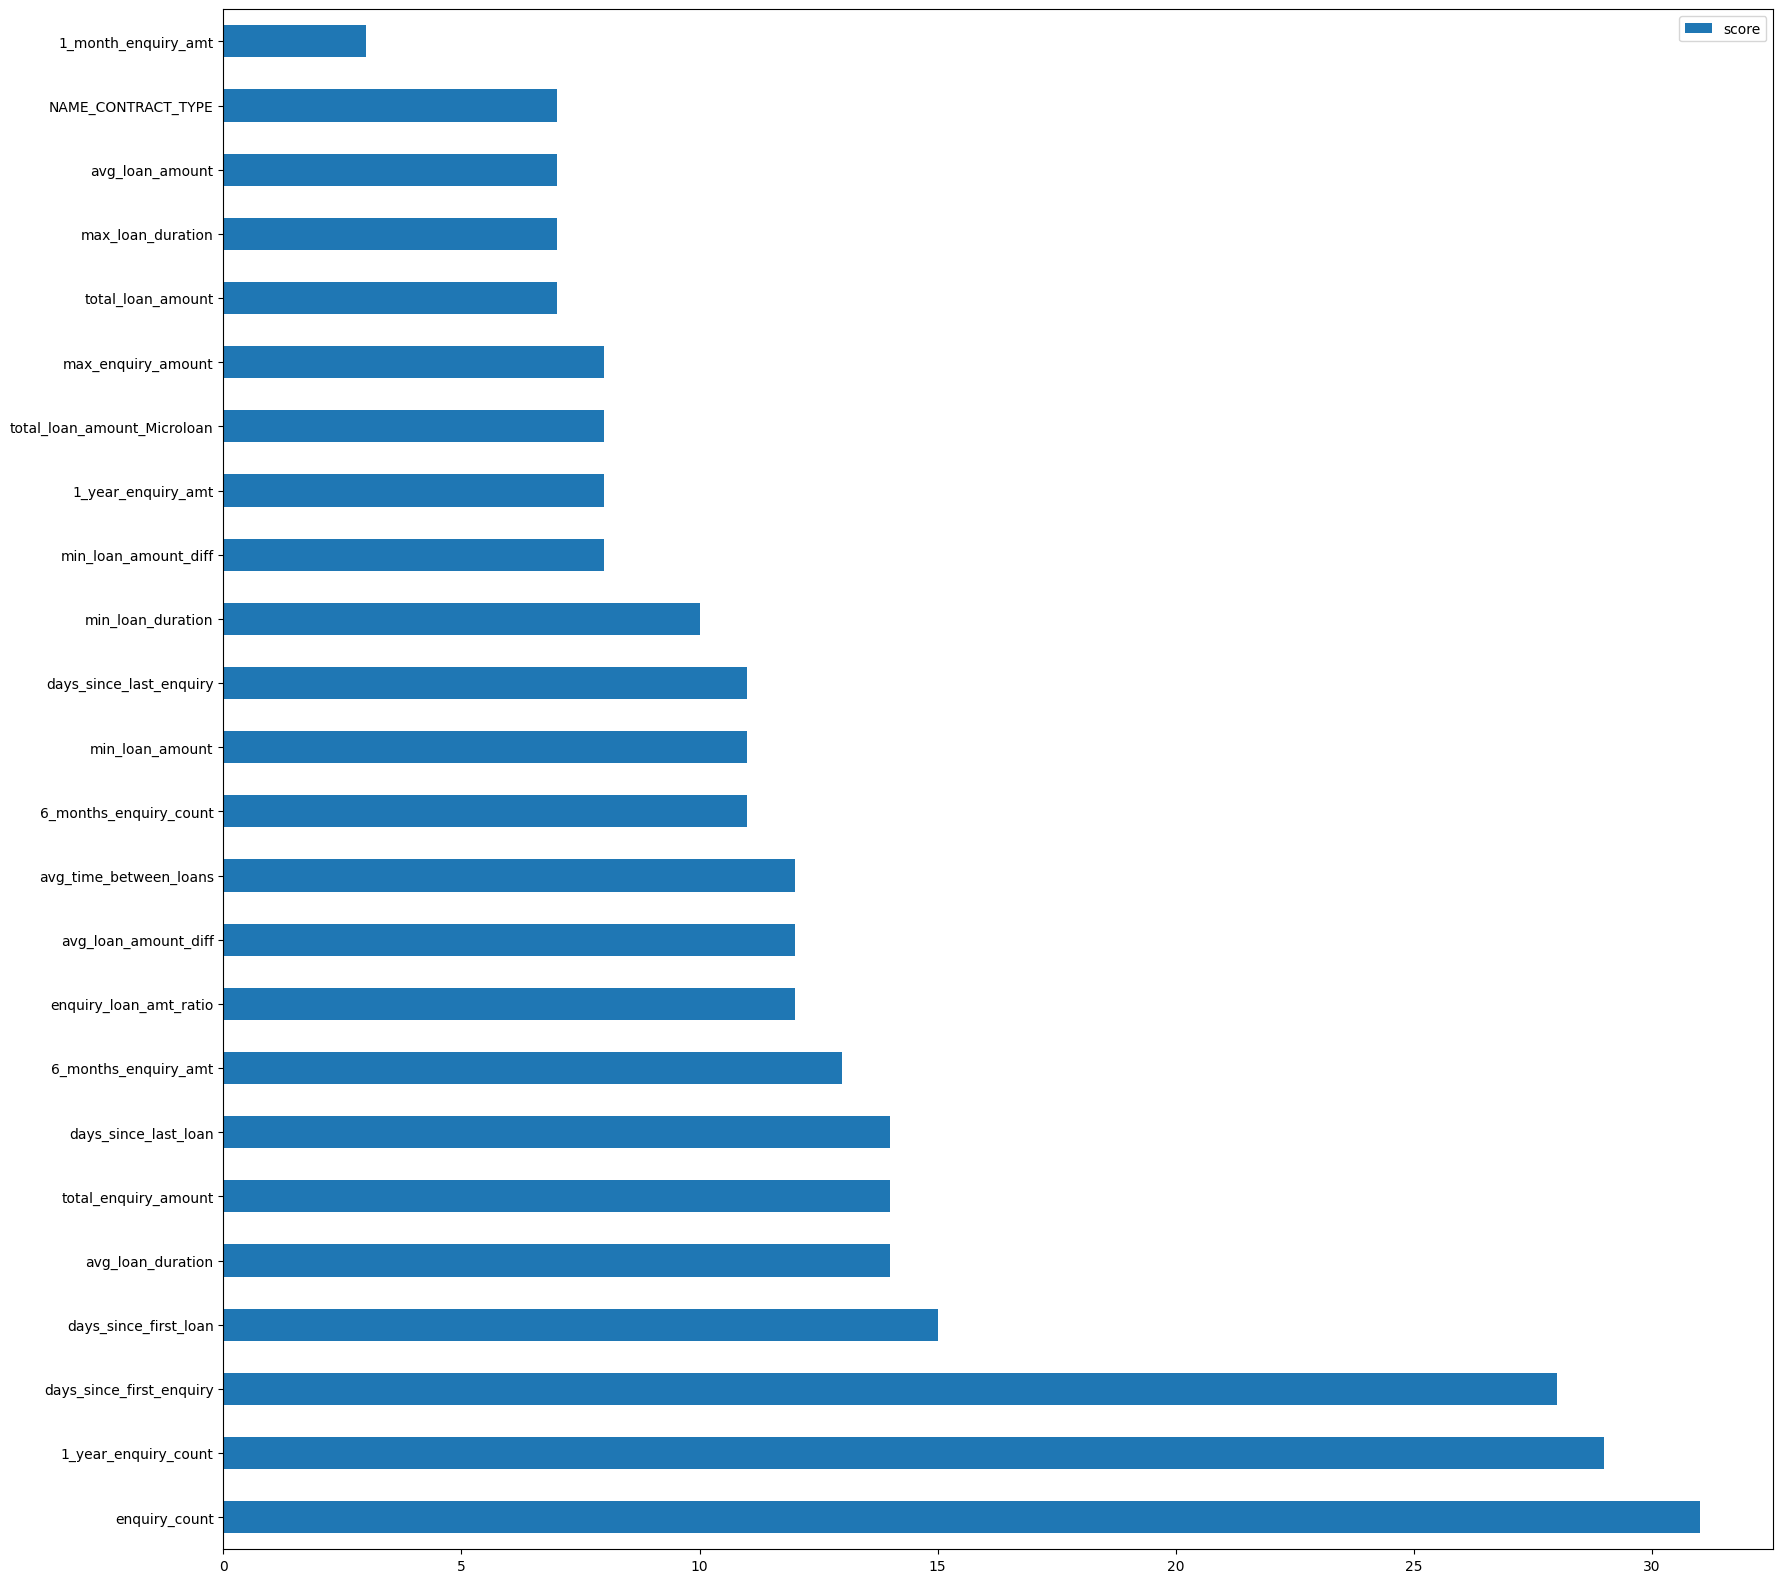

In [9]:
feature_important = pipeline.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(105, columns="score").plot(kind='barh', figsize = (20,20)) ## plot top 40 features

In [12]:
data=test_data.copy()

# Splitting the dataset
X = data.drop(columns=['uid'])
y_pred_prob_xgb = pipeline.predict_proba(X)[:, 1]

In [13]:
test_data["pred"]=list(y_pred_prob_xgb)

In [15]:
res=test_data[["uid","pred"]].copy()
res.to_csv("submission.csv",index=False)